# Residual generator design & simulation for Three-tank example 

Model and design examples
  _Diagnosability Analysis Considering Causal Interpretations for Differential Constraints_, Erik Frisk, Anibal Bregon, Jan Aaslund, Mattias Krysander, Belarmino Pulido, and Gautam Biswas in IEEE Transactions on Systems, Man and Cybernetics, Part A: Systems and Humans (2012), Vol. 42, No. 5, 1216-1229.


In [1]:
%matplotlib notebook
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import sys
import os
from importlib import reload

new_paths = ['../../Models/', '../../Misc/', '../../src/','../../src/faultdiagnosistoolbox/']
[sys.path.append(d) for d in new_paths if not d in sys.path]
from controlpy.synthesis import controller_lqr
from misc import *
import faultdiagnosistoolbox as fdt
from TankSimulation import *

In [2]:
from ThreeTank_model_sym import model
params = {}
params['Rv1'] = 1
params['Rv2'] = 1
params['Rv3'] = 1
params['CT1'] = 1
params['CT2'] = 1
params['CT3'] = 1

model.Lint()

Model: Three Tank System

  Type:Symbolic, dynamic

  Variables and equations
    10 unknown variables
    3 known variables
    6 fault variables
    12 equations, including 3 differential constraints

  Degree of redundancy: 2
  Degree of redundancy of MTES set: 1


  Model validation finished with 0 errors and 0 warnings.


<IPython.core.display.Javascript object>


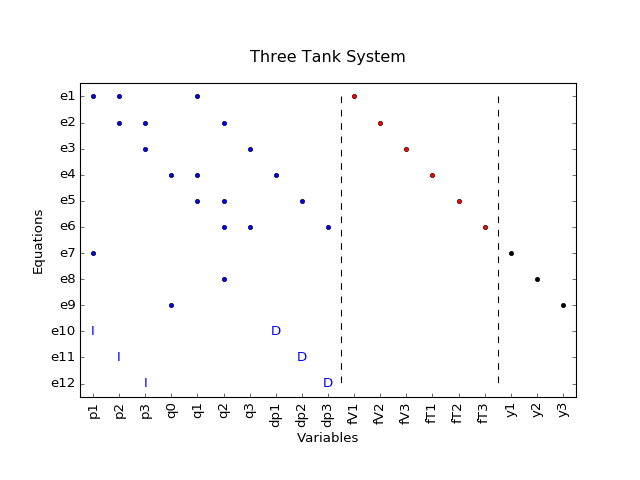

In [3]:
plt.figure(10)
model.PlotModel()

## Isolability analysis

<IPython.core.display.Javascript object>


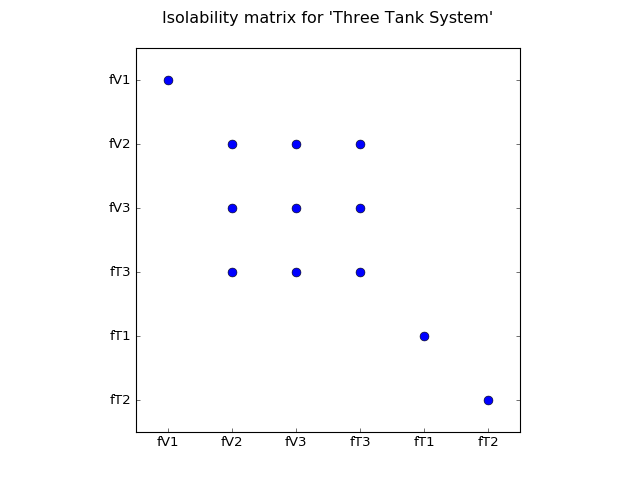

<IPython.core.display.Javascript object>


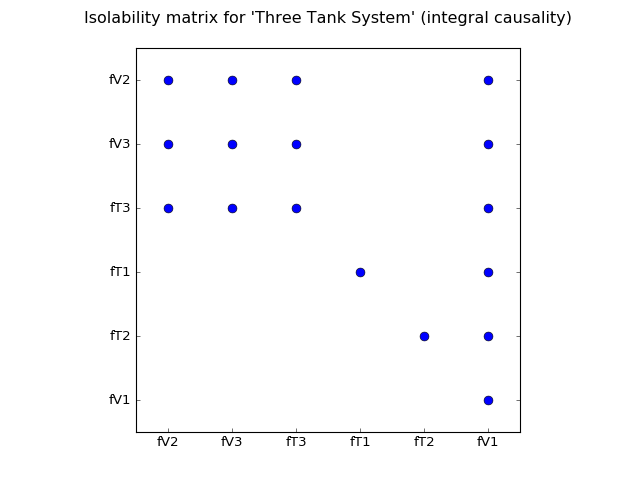

<IPython.core.display.Javascript object>


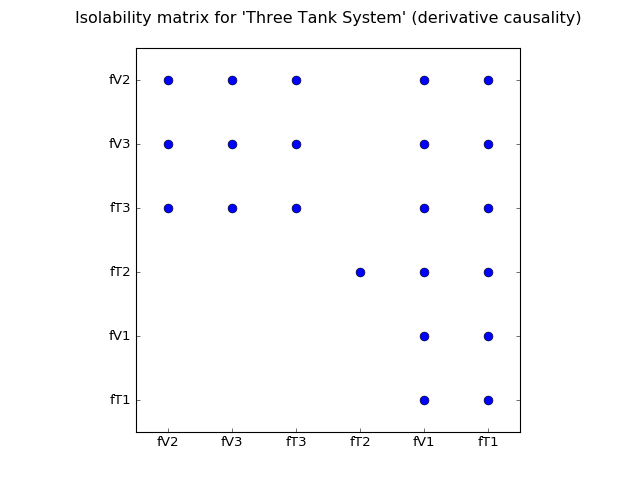

<IPython.core.display.Javascript object>


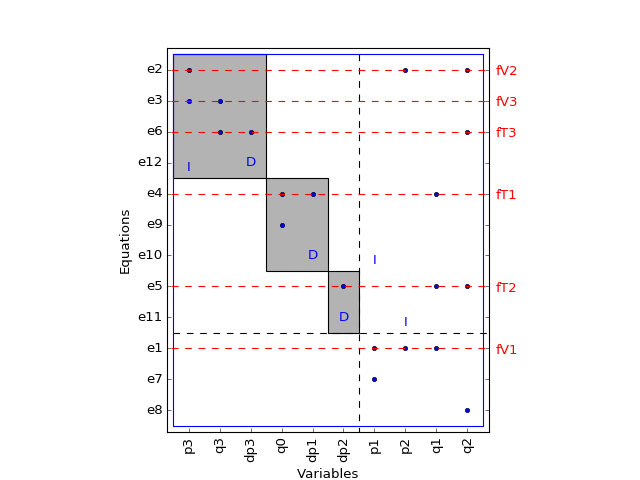

In [4]:
plt.figure(20)
model.IsolabilityAnalysis(plot=True);
plt.figure(21)
model.IsolabilityAnalysis(plot=True,causality='int');
plt.figure(22)
model.IsolabilityAnalysis(plot=True,causality='der');
plt.figure(23)
model.PlotDM(fault=True,eqclass=True)

## MSO

In [5]:
msos = model.MSO()
print("Found " + str(len(msos)) + " MSO sets")

Found 6 MSO sets


In [6]:
mso1 = msos[0]
mso2 = msos[1]
print(model.MSOCausalitySweep(mso1))
print(model.MSOCausalitySweep(mso2))

['mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed']
['der', 'int', 'der', 'mixed', 'mixed', 'mixed', 'int', 'mixed']


# Simulate system and residual generators

Design controller

In [7]:
G = ThreeTank_ss(params)
Lx,_,_ = controller_lqr(G['A'], G['B'], np.eye(3,3),np.eye(1)*0.5)
Lr = (1/np.dot([1,0,0],-inv(G['A']-G['B'].dot(Lx)).dot(G['B'])))[0]
def ref(t):
    return 0.2*np.sin(2*np.pi*1/10*t)+1;
controller = lambda t,x: np.transpose((-Lx.dot(np.transpose(x))+Lr*ref(t)).clip(0))

Simulate scenarios {NF, Rv1, Rv2, Rv3, CT1, CT2, CT3}

In [8]:
noise = 0
t = np.arange(0,20,0.1)
x0 = [0,0,0]
sim = []
sim.append(SimScenario(0,lambda t: 0*t, controller, params, t, x0))
sim.append(SimScenario(1,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))
sim.append(SimScenario(2,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))
sim.append(SimScenario(3,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))
sim.append(SimScenario(4,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))
sim.append(SimScenario(5,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))
sim.append(SimScenario(6,lambda t: 0.3*ramp(t,6,10), controller, params, t, x0))

# Define measurements and add noise
nstd = np.array([0.01,0,0,0,0,0.01,0])*noise;
meas = [0,5,3]; # p1, q2, q0

M = np.zeros((sim[0].z0.shape[1], len(meas)))
M[meas,np.arange(0,len(meas))]=1

for k in range(len(sim)):
    sim[k].z = (sim[k].z0).dot(M) + np.random.normal(0,1,(sim[k].z0.shape[0],len(meas))).dot(np.diag(nstd[meas]))

Plot fault free and Rv1 scenarios

<IPython.core.display.Javascript object>


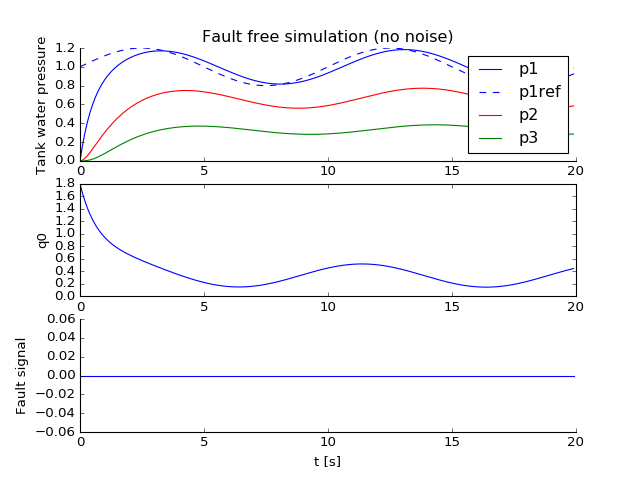

<IPython.core.display.Javascript object>


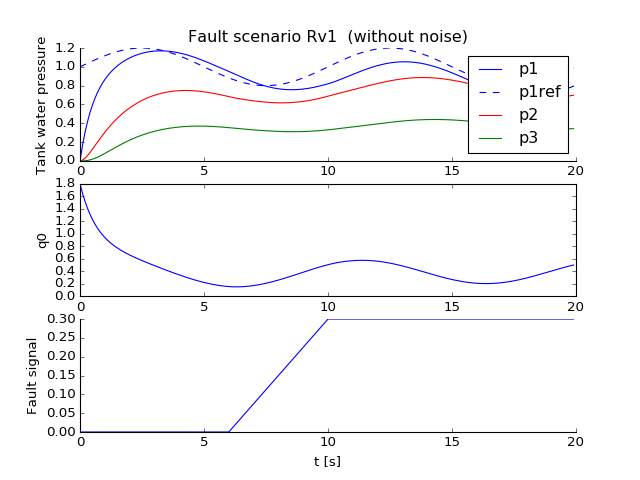

In [9]:
plt.figure(40)
plt.subplot(3,1,1)
plt.plot( sim[0].t, sim[0].z0[:,0], 'b', sim[0].t, ref(sim[0].t), 'b--', 
         sim[0].t, sim[0].z0[:,1], 'r', sim[0].t, sim[0].z0[:,2], 'g')
plt.ylabel('Tank water pressure')
plt.legend(['p1','p1ref','p2','p3'])
plt.title('Fault free simulation (no noise)')

BoxOff()
plt.subplot(3,1,2)
plt.plot( sim[0].t, sim[0].z0[:,3])
plt.ylabel('q0')

plt.subplot(3,1,3)
plt.plot( sim[0].t, sim[0].f)
plt.ylabel('Fault signal')
plt.xlabel('t [s]')
BoxOff()

plt.figure(41)
plt.subplot(3,1,1)
plt.plot( sim[1].t, sim[1].z0[:,0], 'b', sim[1].t, ref(sim[1].t), 'b--', 
         sim[1].t, sim[1].z0[:,1], 'r', sim[1].t, sim[1].z0[:,2], 'g')
plt.ylabel('Tank water pressure')
plt.legend(['p1','p1ref','p2','p3'])
plt.title('Fault scenario Rv1  (without noise)')

BoxOff()
plt.subplot(3,1,2)
plt.plot( sim[1].t, sim[1].z0[:,3])
plt.ylabel('q0')

plt.subplot(3,1,3)
plt.plot( sim[1].t, sim[1].f)
plt.ylabel('Fault signal')
plt.xlabel('t [s]')
BoxOff()


## Residual generator design

In [10]:
# Residual generator 1 in derivative causality (no loops), Fig. 2 in paper
eqr1 = mso2
redeq1 = 4
m01 = [e for e in eqr1 if e != redeq1]
Gamma1 = model.Matching(m01)
#model.SeqResGen( Gamma1, redeq1,'ResGen1',batch=True)
model.SeqResGen( Gamma1, redeq1,'ResGen1',batch=True, language='C')
print("")

# Sequential residual generator in integral causality (no loops) (Fig. 3 in paper)
eqr2 = mso2; 
redeq2 = 6
m02 = [e for e in eqr2 if e != redeq2]
Gamma2 = model.Matching(m02)
#model.SeqResGen( Gamma2, redeq2,'ResGen2',batch=True)
model.SeqResGen( Gamma2, redeq2,'ResGen2',batch=True, language='C')
print("")

# Sequential residual generator in mixed causality (Fig. 12 in paper)
eqr3 = mso1
redeq3 = 1
m03 = [e for e in eqr3 if e != redeq3]
Gamma3 = model.Matching(m03)
#model.SeqResGen( Gamma3, redeq3, 'ResGen3',batch=True )
model.SeqResGen( Gamma3, redeq3, 'ResGen3',batch=True, language='C')

Generating residual generator ResGen1 (C, batch)
  Generating code for the exactly determined part: .......
  Generating code for the residual equations
  Writing residual generator file
Files ResGen1.cc and ResGen1_setup.py generated
Compile by running: python ResGen1_setup.py build_ext --inplace

Generating residual generator ResGen2 (C, batch)
  Generating code for the exactly determined part: ...
  Generating code for the residual equations
  Writing residual generator file
Files ResGen2.cc and ResGen2_setup.py generated
Compile by running: python ResGen2_setup.py build_ext --inplace

Generating residual generator ResGen3 (C, batch)
  Generating code for the exactly determined part: ........
  Generating code for the residual equations
  Writing residual generator file
Files ResGen3.cc and ResGen3_setup.py generated
Compile by running: python ResGen3_setup.py build_ext --inplace


In [11]:
for resName in ['ResGen1', 'ResGen2', 'ResGen3']:
    sys.stdout.write("Compiling residual generator: " + resName + " ... ")
    if os.system("python " + resName + "_setup.py build_ext --inplace")==0:
        sys.stdout.write('Success!\n')
    else:
        sys.stdout.write('Failure!\n')

Compiling residual generator: ResGen1 ... Success!
Compiling residual generator: ResGen2 ... Success!
Compiling residual generator: ResGen3 ... Success!


<IPython.core.display.Javascript object>


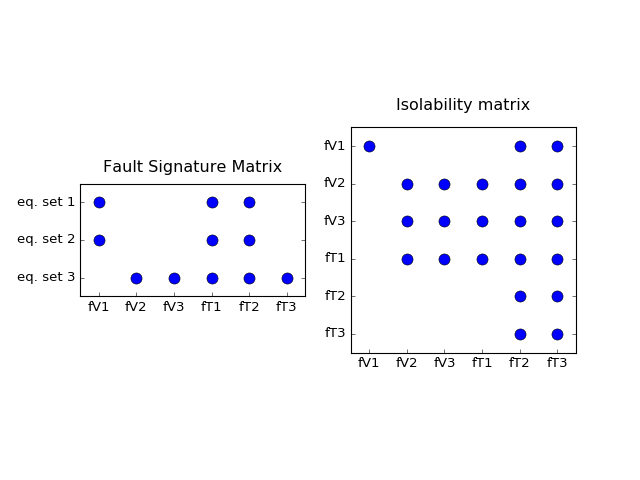

In [12]:
plt.figure(50)
plt.subplot(1,2,1)
FSM = model.FSM([mso2,mso2,mso1],plot=True)
plt.title('Fault Signature Matrix')

plt.subplot(1,2,2)
model.IsolabilityAnalysisFSM(FSM,plot=True)
plt.title('Isolability matrix')
plt.show()

## Simulate residual generators for all test cases and plot results

In [13]:
import ResGen1
import ResGen2
import ResGen3
reload(ResGen1)
reload(ResGen2)
reload(ResGen3)
print("All residual generators imported/reloaded")

All residual generators imported/reloaded


In [14]:
m = len(sim)
N = len(sim[0].t)
Ts = sim[0].t[1]-sim[0].t[0]

r1 = np.zeros((m,N), dtype=np.float64)
r2 = np.zeros((m,N), dtype=np.float64)
r3 = np.zeros((m,N), dtype=np.float64)

for fi in np.arange(0,m):
    state1 = {'p1': sim[fi].z[0,0], 'p2': sim[fi].z[0,1]}
    state2 = {'p1': sim[fi].z[0,0], 'p2': sim[fi].z[0,1]}
    state3 = {'p1': sim[fi].z[0,0], 'p2': sim[fi].z[0,1], 'p3': sim[fi].z[0,2]}

    r1[fi,:] = ResGen1.ResGen1(sim[fi].z,state1,params,Ts)
    r2[fi,:] = ResGen2.ResGen2(sim[fi].z,state2,params,Ts)
    r3[fi,:] = ResGen3.ResGen3(sim[fi].z,state3,params,Ts)
    
    r1[fi,0:2]=0.0
    r3[fi,0] = 0.0

<IPython.core.display.Javascript object>


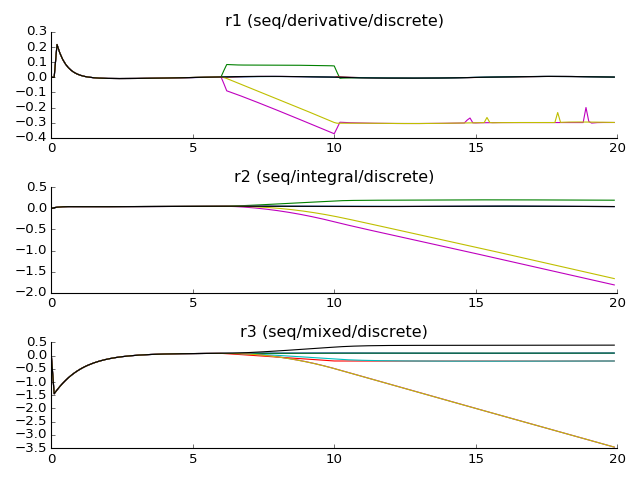

In [15]:
plt.figure(60)
plt.subplot(3,1,1)
for ri in np.arange(0,m):
    plt.plot(sim[0].t, r1[ri,:])
BoxOff()
plt.title('r1 (seq/derivative/discrete)')
#plt.legend(['NF'] + model.f)

plt.subplot(3,1,2)
for ri in np.arange(0,m):
    plt.plot(sim[0].t, r2[ri,:])
BoxOff()
plt.title('r2 (seq/integral/discrete)')


plt.subplot(3,1,3)
for ri in np.arange(0,m):
    plt.plot(sim[0].t, r3[ri,:])
BoxOff()
plt.title('r3 (seq/mixed/discrete)')
plt.tight_layout()